A simple (time-dependent) analytical solution for the temperature equation exists for the case that the initial temperature field is 

$T(x,y,t=0) = T_0 + T_{max} * e^{-\frac{x^2 + y^2}{\sigma^2}}$, 

where Tmax is the maximum amplitude of the temperature perturbation at (x, y) = (0, 0) and σ its half-width.

The solution of the time-dependent PDE is

$T(x,y,t) = T_0 + \frac{T_{max}}{1 + 4t\kappa/\sigma^2} * e^{-\frac{x^2 + y^2}{\sigma^2 +4t\kappa}}$

Set $L_x$ =100km and $L_y$ =80km, $\kappa$ =10$^{−6}$, Q ̃=0, $T_{max}$ =100°C, $T_0$ =200°C, and σ =10$^4$m. Use the previous exercise to generate a nnx×nny grid in the $[−L_x/2,L_x/2]×[−L_y/2,L_y/2]$ domain.
Write a function which takes x, y, t, $T_0$, $T_{max}$, $\kappa$ and σ as argument and returns the analytical temperature value.
Write a an explicit FDM code which solves the 2D diffusion equation. At each time step prescribe on the boundary the analytical solution.

# Ex11.8

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

In [2]:
Lx=100e3           #m
Ly=80e3            #m
kappa=1e-6
Q_=0               #Q/ρCp
Tmax =100          #difference celcius/ K
T0 =200 +273.15    #celcius
sigma=1e4          #m

In [3]:
nnx=11          #np.random.randint()
nny=9           #np.random.randint()
nnp=nnx*nny     #total amount of nodes
hx=Lx/(nnx-1)   #a leap between nodesin x direction
hy=Ly/(nny-1)   #a leap between nodesin x direction

In [4]:
#coordinates in x and y directions respectfully
xcoords=np.tile(np.arange(-Lx/2, Lx/2 + hx/2, hx), nny)
ycoords=np.repeat(np.arange(-Ly/2, Ly/2 + hy/2, hy), nnx)

In [5]:
nnt=100     #total amount of time steps
#time step modified (*27.5/300) for comparison
dt=(0.5*min(hx**2, hy**2)/kappa)*27.5/300

time_end=nnt*dt   #the time at the end

In [6]:
def analytic_T_value(x, y, t, T0, Tmax, kappa, sigma):
  #T(x,y,t) = T0 + Tmax * exp( -(x^2 + y^2) / (σ^2 + 4tkappa)) / (1 + 4tkappa/σ^2)
  return T0 + Tmax * np.exp(-(x**2 + y**2)/(sigma**2 + 4*t*kappa)) / (1 + 4*t*kappa/(sigma**2))

In [7]:
#analytical solution at the end of computation
Tref=np.zeros((nnp))

for k in range(nnp):
  Tref[k] = analytic_T_value(xcoords[k], ycoords[k], time_end, T0, Tmax, kappa, sigma)

In [8]:
#conditions at time step=0
Tinitial=np.copy(Tref)

for k in range(nnx, nnp-nnx):
  if k%nnx and (k+1)%nnx:
    Tinitial[k] = T0 + Tmax * np.exp(-(xcoords[k]**2 + ycoords[k]**2)/(sigma**2))

In [9]:
def the_ftcs_step(Told_ftcs, hx_ftcs, hy_ftcs, kappa_ftcs, dt_ftcs, Q__ftcs, Tref_ftcs, nnx_ftcs, nny_ftcs):
  Tnew_ftcs = np.copy(Tref_ftcs)
  nnp_ftcs = nnx_ftcs*nny_ftcs
  sx, sy = kappa_ftcs*dt_ftcs/(hx_ftcs**2), kappa_ftcs*dt_ftcs/(hy_ftcs**2)

#Tnew_ftcs[w][e]= sx * (Told_ftcs[w][e-1] - 2*Told_ftcs[w][e] + Told_ftcs[w][e+1]) +
#                 sy * (Told_ftcs[w-1][e] - 2*Told_ftcs[w][e] + Told_ftcs[w+1][e]) + Q__ftcs*dt + Told_ftcs[w][e]

  for k in range(nnx_ftcs, nnp_ftcs-nnx_ftcs):
    if k%nnx_ftcs and (k+1)%nnx_ftcs:
      Tleft, Tright, Tupearly, Tlowetly = Told_ftcs[k-1], Told_ftcs[k+1], Told_ftcs[k-nnx_ftcs], Told_ftcs[k+nnx_ftcs]
      Tnew_ftcs[k] = sx*(Tleft - 2*Told_ftcs[k] + Tright) + sy*(Tupearly - 2*Told_ftcs[k] + Tlowetly) + Q__ftcs*dt_ftcs + Told_ftcs[k]

  return Tnew_ftcs

In [10]:
#looping over time
time1=time.time()
Tinitial_new=np.copy(Tinitial)
storage_explicit=[(Tinitial_new -273.15).reshape((nny,nnx))]

for _ in range(nnt):
  Tnew=the_ftcs_step(Tinitial_new, hx, hy, kappa, dt, Q_, Tref, nnx, nny)
  Tinitial_new[:]=Tnew[:]
  storage_explicit.append((Tnew-273.15).reshape((nny,nnx)))
time2=time.time()

print(f'''Time required for FDM explicit 
if nnt={nnt} time steps and nnp={nnp} and dt x{round(dt / (0.5*min(hx**2, hy**2)/kappa), 4)}
is {round(time2-time1,4)} seconds''')

Time required for FDM explicit 
if nnt=100 time steps and nnp=99 and dt x0.0917
is 0.0272 seconds


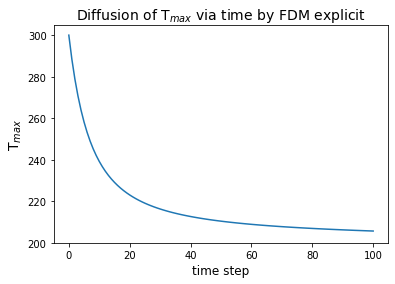

In [11]:
plt.plot(list(range(nnt+1)), 
         list(map(lambda x: max(x.flatten()), storage_explicit)))
plt.title(r'Diffusion of T$_{max}$ via time by FDM explicit', fontsize=14)
plt.xlabel('time step', fontsize=12)
plt.ylabel(r'T$_{max}$', fontsize=14)
plt.ylim(bottom=200)

#plt.savefig('2d fdm explicit diffusion Tmax evo.pdf')
#plt.savefig('2d fdm explicit diffusion Tmax evo.png', transparent=True, dpi=600)
plt.show()

# comparison of different dt

In [12]:
dt1=(0.5*min(hx**2, hy**2)/kappa)
dt2=(0.5*min(hx**2, hy**2)/kappa)/10
dt3=(0.5*min(hx**2, hy**2)/kappa)/100
dt4=(0.5*min(hx**2, hy**2)/kappa)/2

In [13]:
storage_Tmax=[]
dt_storage= sorted([dt1, dt2, dt3, dt4])[::-1]

for i in dt_storage:
  #ref
  Tref_trial=np.zeros((nnp))
  for k in range(nnp):
    Tref_trial[k] = analytic_T_value(xcoords[k], ycoords[k], nnt*i, T0, Tmax, kappa, sigma)

  #initial
  Tinitial_trial=np.copy(Tref_trial)
  for k in range(nnx, nnp-nnx):
    if k%nnx and (k+1)%nnx:
      Tinitial_trial[k] = T0 + Tmax * np.exp(-(xcoords[k]**2 + ycoords[k]**2)/(sigma**2))

  #looping over time
  Tinitial_new_trial=np.copy(Tinitial_trial)
  storage_trial=[max(Tinitial_new_trial -273.15)]

  for _ in range(nnt):
    Tnew_trial=the_ftcs_step(Tinitial_new_trial, hx, hy, kappa, i, 
                             Q_, Tref_trial, nnx, nny)
    Tinitial_new_trial[:]=Tnew_trial[:]
    storage_trial.append(max(Tnew_trial-273.15))
  
  #save
  storage_Tmax.append(storage_trial)

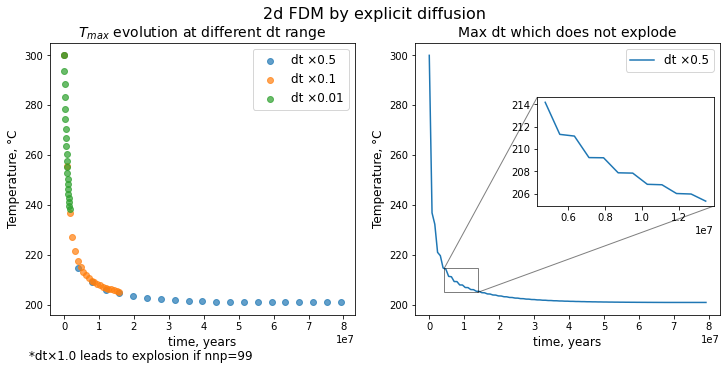

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('2d FDM by explicit diffusion', fontsize=16)

for i in range(len(storage_Tmax)):
  if max(storage_Tmax[i]) > 401:
    k=i
    staik=dt_storage[i]/(0.5*min(hx**2, hy**2)/kappa)
    plt.figtext(0.1, -0.1*(i), 
                f'*dt×{round(staik, 3)} leads to explosion if nnp={nnp}', 
                fontsize=12)
  else: 
    staik=round(dt_storage[i]/(0.5*min(hx**2, hy**2)/kappa),2)
    ax1.scatter(np.arange(nnt+1)[::5]*dt_storage[i]/3600/24/365.25, 
                storage_Tmax[i][::5], alpha=0.7, label=f'dt ×{staik}')

ax1.set_title(r'$T_{max}$ evolution at different dt range', fontsize=14)
ax1.set_xlabel('time, years', fontsize=12)
ax1.set_ylabel('Temperature, °C', fontsize=12)
ax1.legend(fontsize=12)

ax2.plot(np.arange(nnt+1)*dt_storage[k+1]/3600/24/365.25, storage_Tmax[k+1],
         label=f'dt ×{round(dt_storage[k+1]/(0.5*min(hx**2, hy**2)/kappa),2)}')
ax2.set_title('Max dt which does not explode', fontsize=14)
ax2.set_xlabel('time, years', fontsize=12)
ax2.set_ylabel('Temperature, °C', fontsize=12)
ax2.legend(fontsize=12)

right_inset_ax = ax2.inset_axes([.4, .4, .58, .4])
x=np.arange(nnt+1)*dt_storage[k+1]/3600/24/365.25
y=storage_Tmax[k+1]
right_inset_ax.plot(x[len(x)//16:3*len(x)//16], y[len(y)//16:3*len(y)//16])
ax2.indicate_inset_zoom(right_inset_ax, edgecolor="black")

# plt.savefig('2d fdm explicit dif dt Tmax evo.pdf')
# plt.savefig('2d fdm explicit dif dt Tmax evo.png', transparent=True, dpi=600)
plt.show()

# pics

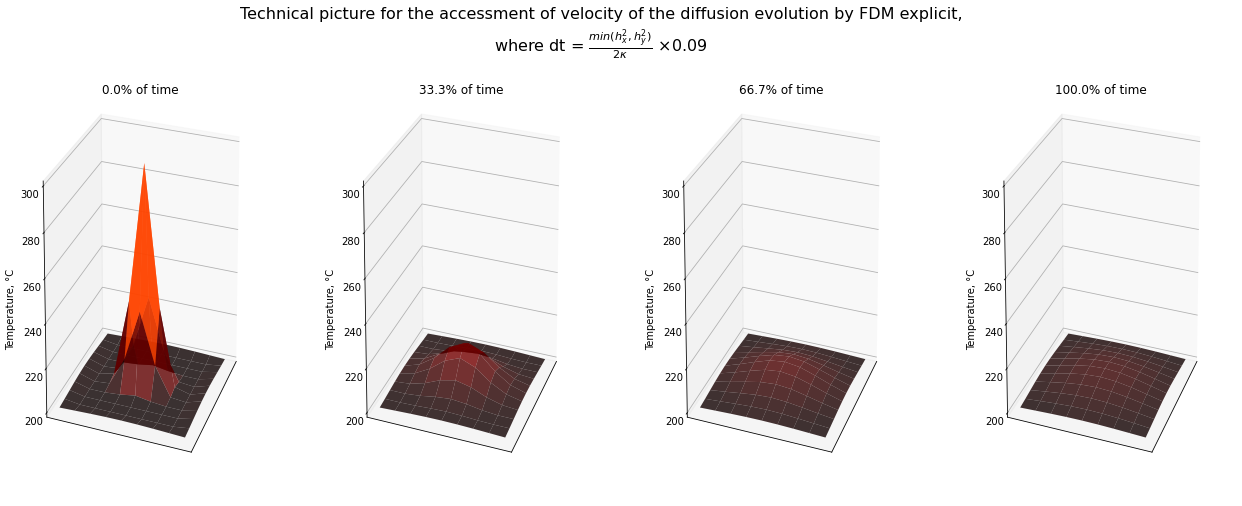

In [15]:
fig = plt.figure(figsize=(22,8))
fig.suptitle('Technical picture for the accessment of velocity of the diffusion evolution by FDM explicit,\n' +
             r'where dt = $\frac{min(h^2_x, h^2_y)}{2\kappa}$ ' + 
             f'×{round(dt/(0.5*min(hx**2, hy**2)/kappa),2)}', fontsize=16)

for i in range(4):
  ax = fig.add_subplot(1, 4, i+1, projection='3d')
  surf = ax.plot_surface(xcoords.reshape((nny,nnx)), ycoords.reshape((nny,nnx)), 
                         storage_explicit[(nnt*i)//4].reshape((nny,nnx)), 
                         cmap='hot', alpha=0.8, vmin=200, vmax=300)
  ax.set_zlim(200, 300)
  ax.view_init(20,200)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'{round(i*100/3,1)}% of time')
  ax.zaxis.set_rotate_label(False)
  ax.set_zlabel("Temperature, °C\n", rotation=90)

#plt.savefig('2d evo fdm explicit.pdf')
#plt.savefig('2d evo fdm explicit.png', transparent=True, dpi=600)
plt.show()

In [16]:
#3d interactive visualisition
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=storage_explicit[1])])
fig.show()

In [17]:
fig = go.Figure(data=[go.Surface(z=storage_explicit[0])],
    layout=go.Layout(updatemenus=[dict(type="buttons", buttons=[dict(label="Play", method="animate", args=[None])])]),
    frames=[go.Frame(data=[go.Surface(z=k)], name=str(i)) for i, k in enumerate(storage_explicit)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="tomato", project_z=True), colorscale='magma')

fig.update_layout(title='data HEATPILES', autosize=False, width=650, height=500, margin=dict(l=0, r=0, b=0, t=0))

def frame_args(duration):
    return {"frame": {"duration": duration}, "mode": "immediate", "fromcurrent": True, 
            "transition": {"duration": duration, "easing": "linear"},}

sliders = [{"pad": {"b": 10, "t": 60}, "len": 0.9, "x": 0.1, "y": 0,
            "steps": [{"args": [[f.name], frame_args(0)], "label": str(k), "method": "animate",} for k, f in enumerate(fig.frames)],}]
    
fig.update_layout(sliders=sliders)

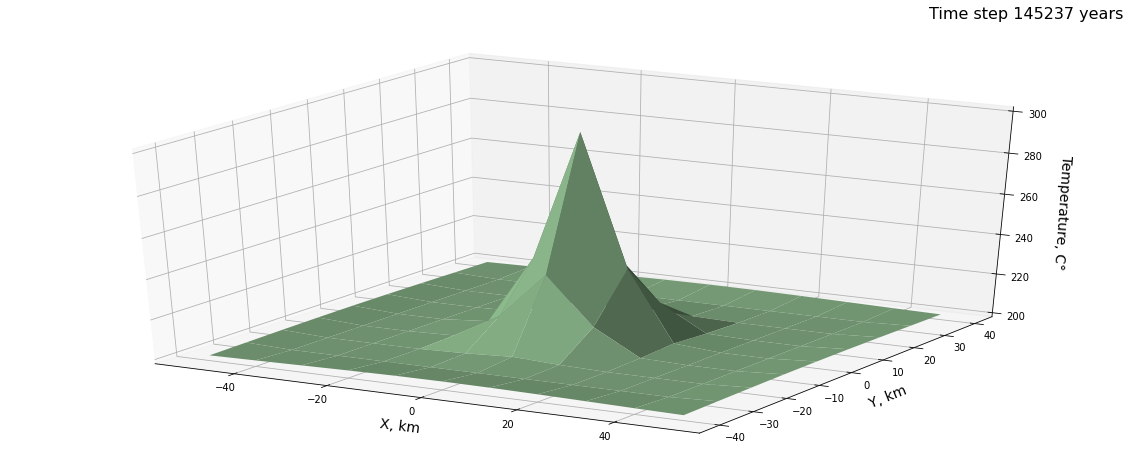

In [18]:
fig = plt.figure(figsize=(20,8))
ax = fig.gca(projection='3d')
ax = fig.add_subplot(projection='3d')

ax.plot_surface(xcoords.reshape((nny,nnx))/1e3, ycoords.reshape((nny,nnx))/1e3, 
                storage_explicit[0], color = 'darkseagreen') #Tnew.reshape((nny,nnx))

ax.set_xlabel('\nX, km', fontsize=14, rotation=-10)
ax.set_ylabel('\nY, km', fontsize=14, rotation=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Temperature, C°\n', fontsize=14, rotation=266)
plt.title('Time step %.2d years' %(dt/3600/24/365.25), loc='right', fontsize=16)
plt.grid()

plt.show()

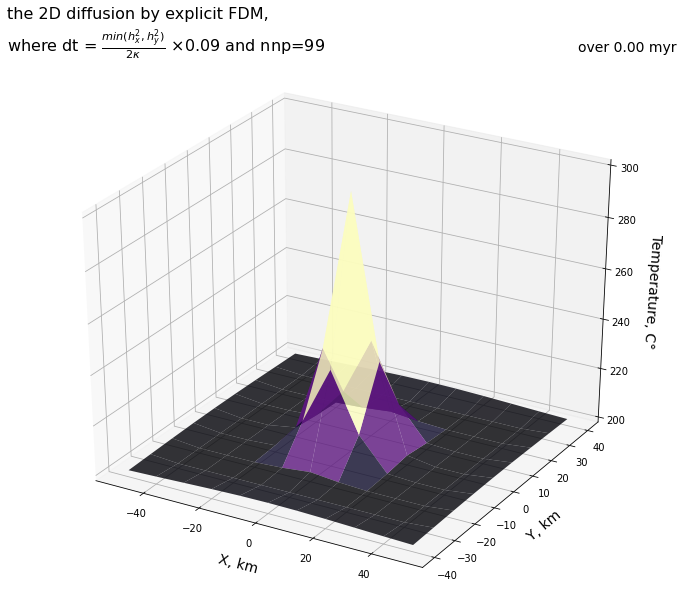

In [21]:
def update_plot(frame_number, zarray, plot):
  plot[0].remove()
  plot[0] = ax.plot_surface(x, y, zarray[frame_number], cmap="magma", alpha=0.8)
  ax.set_title("over %.2f myr" % (frame_number*dt/3600/24/365.25/1e6), 
               loc='right', fontsize=14)
  ax.set_zlim(200, 300)

fig = plt.figure(figsize=(12, 10))
ax = fig.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('\nX, km', fontsize=14, rotation=-10)
ax.set_ylabel('\nY, km', fontsize=14, rotation=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Temperature, C°\n', fontsize=14, rotation=266)
ax.set_zlim(200, 300)

ax.set_title("the 2D diffusion by explicit FDM,\n" + 
             r'where dt = $\frac{min(h^2_x, h^2_y)}{2\kappa}$ ' + 
             f'×{round(dt/(0.5*min(hx**2, hy**2)/kappa),2)} and nnp={nnp}', 
             loc='left', fontsize=16)

N = 14
nmax = nnt
x, y = xcoords.reshape((nny, nnx))/1e3, ycoords.reshape((nny, nnx))/1e3

plot = [ax.plot_surface(x, y, storage_explicit[0], color='0.75', rstride=1, cstride=1)]


animate = animation.FuncAnimation(fig, update_plot, nmax, interval=40, fargs=(storage_explicit, plot))
#animate.save('matplot009.gif', writer="imagemagick")
f = r"2D diffusion by explicit.gif"
writergif = animation.PillowWriter()#fps=60
animate.save(f, writer=writergif)
plt.show()